In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import wordcloud as wc
import collections
import seaborn as sbn
import nltk
import os
import collections
import itertools  
from wordcloud import STOPWORDS,WordCloud
from pandas import DataFrame, read_csv
from nltk import word_tokenize, BigramCollocationFinder
from nltk.corpus import stopwords as stopwords2
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from sklearn import svm,metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix,make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB,CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from IPython.display import HTML
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
%matplotlib inline
punctuation = list(punctuation)
punctuation.append('’')

In [2]:
directoryPath = r"C:\Users\nikol\Desktop\fulltext\data\\"
# directoryPath = r"C:\Users\myrto\Desktop\data\\"
categories = os.listdir(directoryPath)
categories.remove('README.TXT')

df = pd.DataFrame(columns=['id','title','content','category'])

id=0
for category in categories:
    path = directoryPath + category
    txtfiles = os.listdir(path)
    for txt in txtfiles:    
        filepath = path + "\\" + txt
        file = open(filepath,"r")
        filecontent = file.readlines()
        title = filecontent[0].replace("\n","")
        del filecontent[0]
        content = "".join(filecontent)
        df.loc[id] = [id,title,content,str(category)]
        id+=1
df.to_csv("final.csv")

In [65]:
# test_with_category = test.copy()
# test.drop(columns='category',inplace=True)
# train = train.reset_index()
# test = test.reset_index()
# test.drop(columns='index',inplace=True)
# train.drop(columns='index',inplace=True)
# train.to_csv("train_set.tsv",sep="\t")
# train.to_csv("test_set.tsv",sep="\t")

In [3]:
stopwordsPath = r"C:\Users\nikol\Desktop\Project-2-DataMining-\\english_stopwords.txt"
# stopwordsPath = r"C:\Users\myrto\Documents\GitHub\Project-2-DataMining-\english_stopwords.txt"
file = open(stopwordsPath,"r",errors='ignore')
stopwords_fromHub = [x.replace('\n',"") for x in file.readlines()]
stopwords = set(STOPWORDS)
stopwords2 =  set(stopwords2.words('english'))
stopwords.update(stopwords2)
stopwords.update(set(stopwords_fromHub))

# 1. WordClouds

In [5]:
def generate_WordCloud(data,stopwords):
    textWords = []
    for x in data:
        for y in word_tokenize(x) :
            y = y.lower()
            y = WordNetLemmatizer().lemmatize(y)
            if (y not in stopwords) and (y not in punctuation) and y.isalpha():
                textWords.append(y)
                
    counter = collections.Counter(textWords)
    words = WordCloud(background_color='black',stopwords=stopwords,margin=0).generate_from_frequencies(frequencies=dict(counter))

    plt.figure(figsize=(20,10))
    plt.imshow(words,interpolation='bilinear')
    plt.axis("off")
    plt.show()

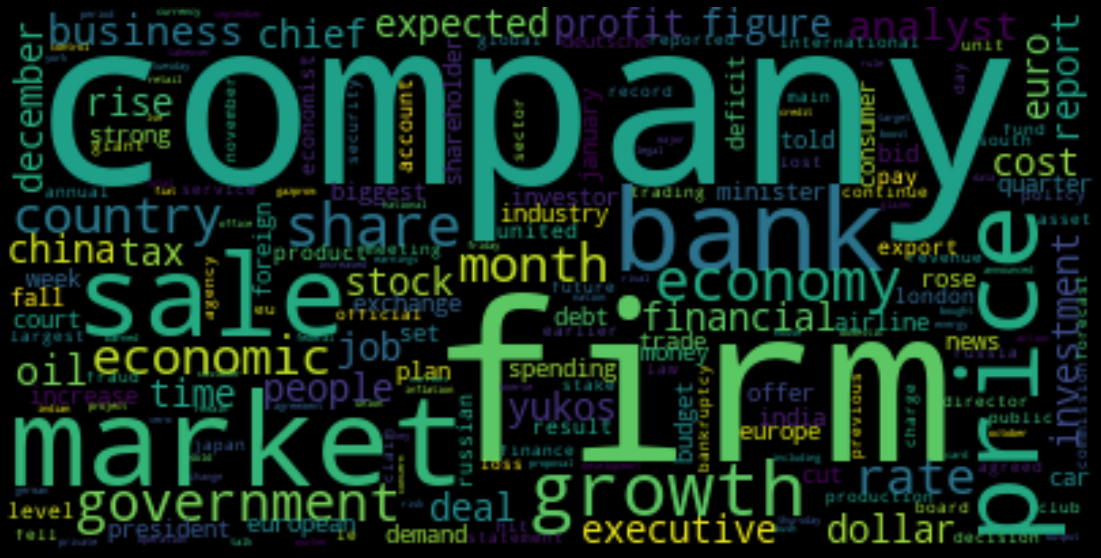

In [32]:
temp = df.loc[df['category'] == 'business']
generate_WordCloud(temp['content'],stopwords)

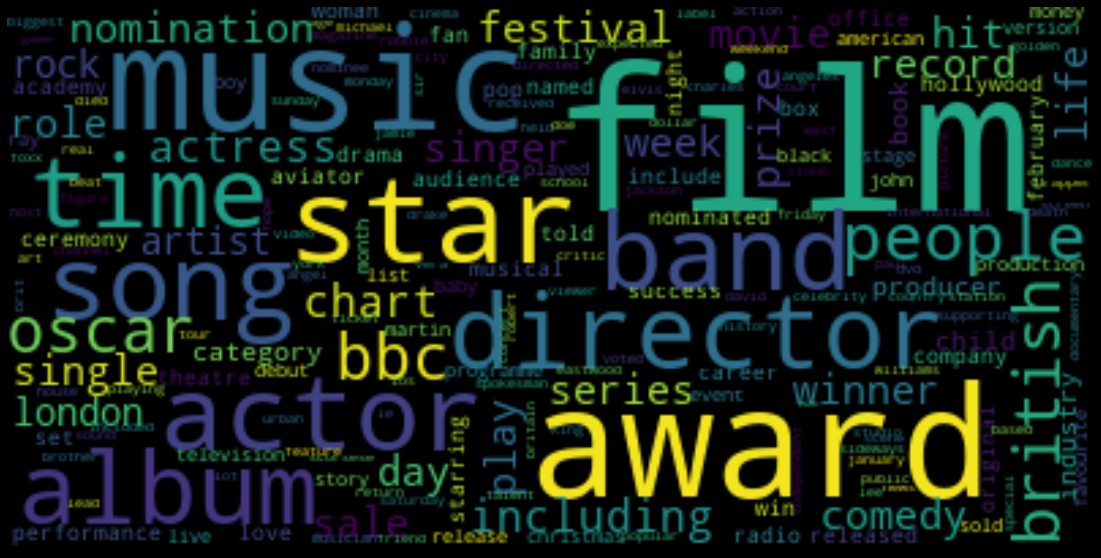

In [33]:
temp = df.loc[df['category'] == 'entertainment']
generate_WordCloud(temp['content'],stopwords)

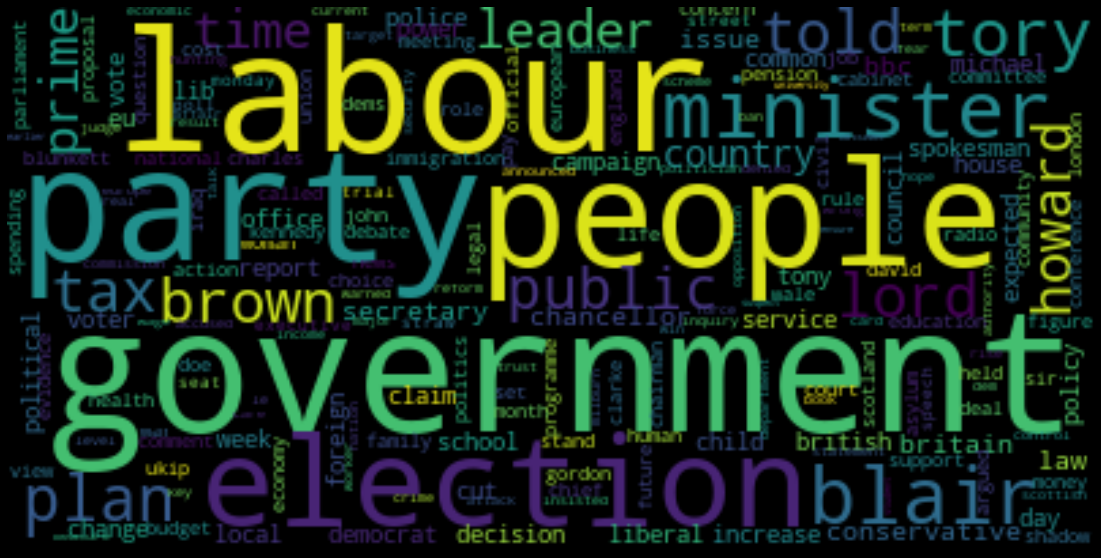

In [34]:
temp = df.loc[df['category'] == 'politics']
generate_WordCloud(temp['content'],stopwords)

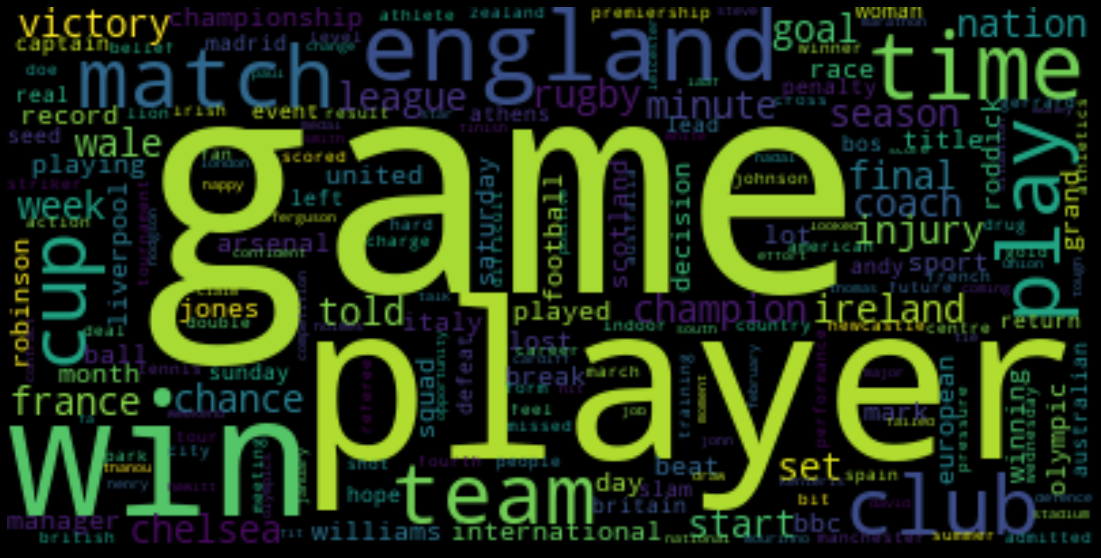

In [35]:
temp = df.loc[df['category'] == 'sport']
generate_WordCloud(temp['content'],stopwords)

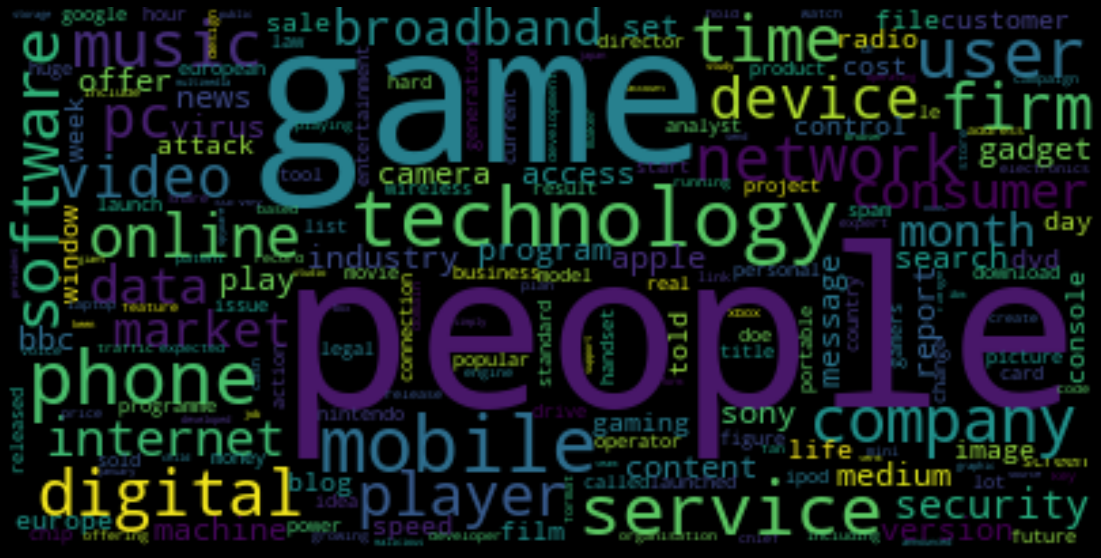

In [36]:
temp = df.loc[df['category'] == 'tech']
generate_WordCloud(temp['content'],stopwords)





#        2. Classification 






In [4]:
y = df['category']
X = df['content']

In [5]:
def vectorizeData(X_train,X_test,vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train,X_test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)

le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

tfidfVectorizer = TfidfVectorizer(max_df=1.0,min_df=1,stop_words=stopwords)
tfidf_train,tfidf_test = vectorizeData(X_train,X_test,tfidfVectorizer)

bowVectorizer = CountVectorizer(stop_words=stopwords)
bow_train,bow_test = vectorizeData(X_train,X_test,bowVectorizer)

folds = StratifiedKFold(n_splits=10)
classes = le.classes_

In [7]:
def estimator(estimator,parameter_grid,X_train,X_test,y_train,y_test):
    if parameter_grid: 
        grid = GridSearchCV(estimator,parameter_grid,cv=folds,refit=False,return_train_score=False,scoring=['accuracy','precision_macro','recall_macro','f1_macro'])
        grid.fit(X_train, y_train)  # fitting the model for grid search 
        tempDf = pd.DataFrame(grid.cv_results_)
    else:
        cv_results = cross_validate(estimator,X_train,y_train,cv = folds,scoring = ['accuracy','precision_macro','recall_macro','f1_macro'])
        tempDf = pd.DataFrame(cv_results,columns=['test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'])        
    return tempDf

In [8]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: darkred' if v else '' for v in is_max]

In [9]:
def create_plots(estimator,y_test,t_test,b_test,folds,modelName):
    clf = OneVsRestClassifier(estimator)
    tfidf_predictions = cross_val_predict(estimator,t_test,y_test,cv=folds,method='predict')
    bow_predictions = cross_val_predict(estimator,b_test,y_test,cv=folds,method='predict')
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))
    fig.suptitle(modelName,fontsize=25,fontweight='bold')
    create_ROCplot(5,tfidf_predictions,y_test,ax1,'Tf-idf Vectorizer')    
    create_ROCplot(5,bow_predictions,y_test,ax2,'BoW Vectorizer')  

In [10]:
from sklearn import datasets
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle

def create_ROCplot(n_classes,predictions,y_test,ax,title):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(predictions))[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lw=2

    ax.plot(fpr["macro"],tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["macro"]),color='green', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','red','darkred'])
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color,lw=lw,label='Class - {0} - (area = {1:0.2f})'''.format(classes[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.annotate('Random Guess',(.5,.48),color='red')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax.legend(loc="lower right")

In [11]:
def make_Classification(model,parameters,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,wantedColumns,nameDict):

    tfidf_df = estimator(model,parameters,tfidf_train,tfidf_test, y_train, y_test)
    bow_df = estimator(model,parameters,bow_train,bow_test, y_train, y_test)
    tfidf_df.insert(0,'Vectorizer','Tf-idf')
    bow_df.insert(0,'Vectorizer','BoW')
    tfidf_df  = pd.DataFrame(tfidf_df,columns=wantedColumns)
    bow_df  = pd.DataFrame(bow_df,columns=wantedColumns)
    model_df = pd.concat([tfidf_df,bow_df],ignore_index=True)
    model_df.rename(columns=nameDict,inplace=True)
    return model_df




# $\bullet$ Support Vector Machines


 

In [56]:
SVM_param = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['rbf','linear']
}

svmDf = make_Classification(
    svm.SVC(),
    SVM_param,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','param_C', 'param_gamma', 'param_kernel','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_C': 'C', 'param_gamma' : 'gamma', 'param_kernel':'Kernel','mean_test_accuracy':'Accuracy','mean_test_precision_macro':'Precision (macro)',
                'mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'}
)
svmDf.style.format("{:.2f}",subset=['C','gamma']).format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

In [24]:
SVM_param = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['rbf','linear']
}

svmDf_tfidf = estimator(svm.SVC(),SVM_param,tfidf_train,tfidf_test, y_train, y_test)
svmDf_bow = estimator(svm.SVC(),SVM_param,bow_train,bow_test, y_train, y_test)
svmDf_tfidf.insert(0,'Vectorizer','Tf-idf')
svmDf_bow.insert(0,'Vectorizer','BoW')
svmDf_tfidf = svmDf_tfidf[['Vectorizer','param_C', 'param_gamma', 'param_kernel','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro']]
svmDf_bow = svmDf_bow[['Vectorizer','param_C', 'param_gamma', 'param_kernel','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro']]
svmDf = pd.concat([svmDf_tfidf,svmDf_bow],ignore_index=True)
svmDf.rename(columns={'param_C': 'C', 'param_gamma' : 'gamma', 'param_kernel':'Kernel','mean_test_accuracy':'Accuracy','mean_test_precision_macro':'Precision (macro)','mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'},inplace=True)
svmDf.style.format("{:.2f}",subset=['C','gamma']).format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

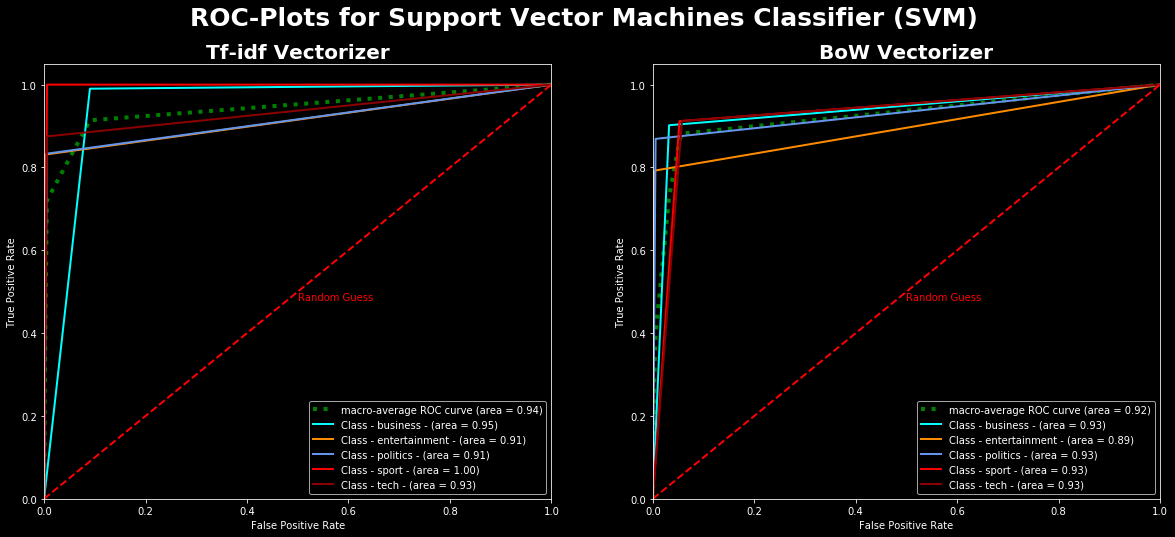

In [25]:
create_plots(svm.SVC(),y_test,tfidf_test,bow_test,folds,'ROC-Plots for Support Vector Machines Classifier (SVM)')


# $\bullet$ RandomForestClassifier


In [27]:
randomForest_parameters = {
    'n_estimators' : [1,10],
    'criterion'    : ['gini','entropy']
}

rfcdf = make_Classification(
    RandomForestClassifier(),
    randomForest_parameters,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','param_n_estimators', 'param_criterion','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_n_estimators': 'n_estimators', 'param_criterion' : 'Criterion', 'mean_test_accuracy':'Accuracy',
                'mean_test_precision_macro':'Precision (macro)','mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'},
)
rfcdf.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

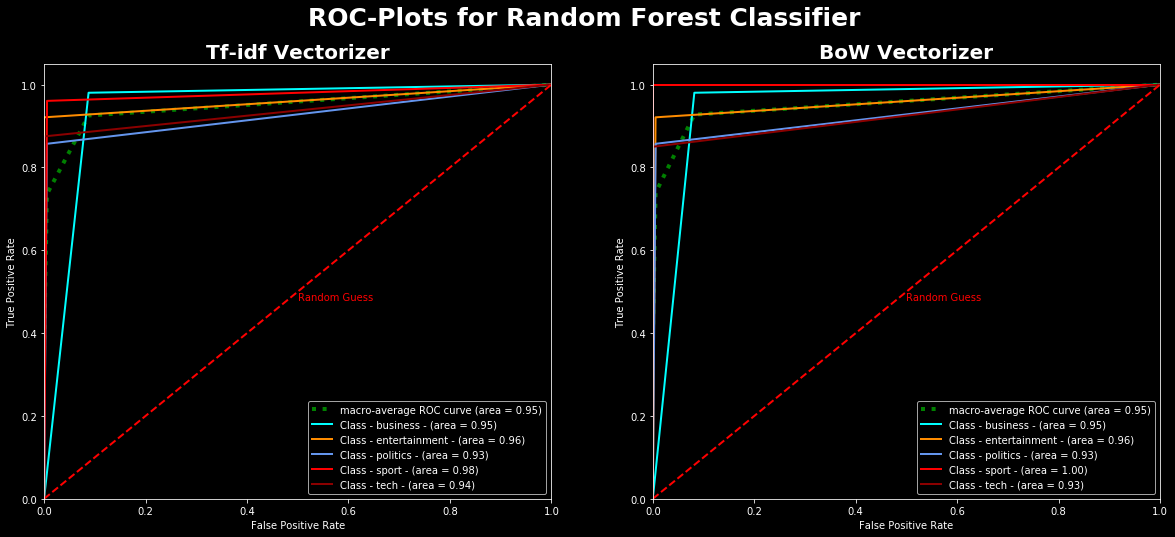

In [80]:
create_plots(RandomForestClassifier(),y_test,tfidf_test,bow_test,folds,'ROC-Plots for Random Forest Classifier')



# $\bullet$ Naive Bayes


 Data processing for *Naive Bayes* algorithms

In [30]:
tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()
bow_train = bow_train.toarray()
bow_test = bow_test.toarray()

#  *Gaussian*

In [31]:
emptydict = {}

nb = make_Classification(
    GaussianNB(),
    emptydict,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
nb.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

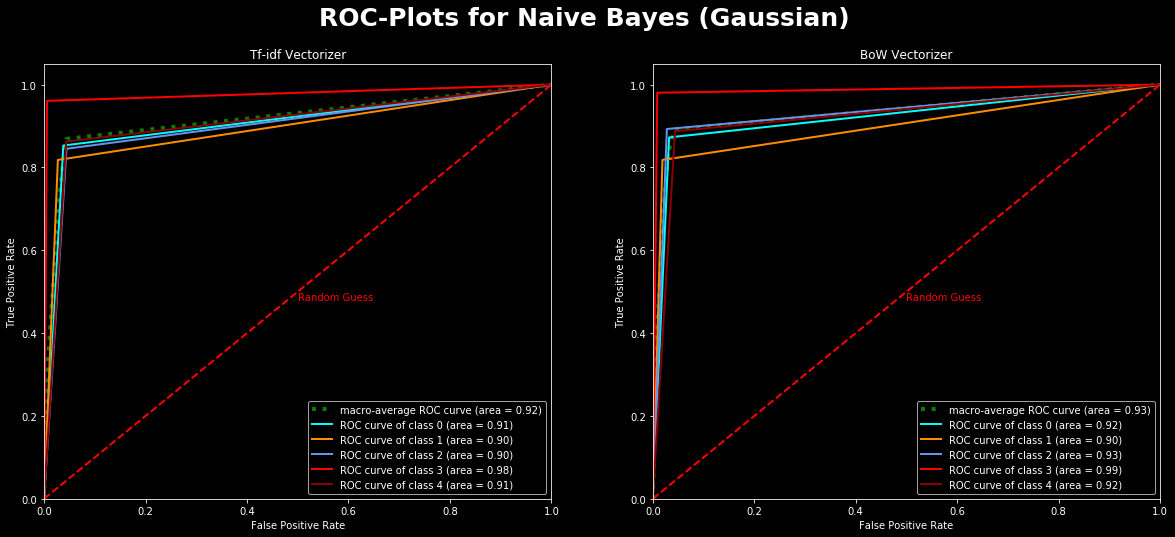

In [79]:
create_plots(GaussianNB(),y_test,tfidf_test,bow_test,folds,'ROC-Plots for Naive Bayes (Gaussian)')

#  Comparison between different Naive Bayes algorithms : *Gaussian,Bernoulli and Multinomial*  

In [32]:
emptydict = {}
gaussianNB = make_Classification(
    GaussianNB(),
    emptydict,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
gaussianNB.insert(0,'Naive Bayes Algorithm','GaussianNB')

bernoulliNB = make_Classification(
    BernoulliNB(),
    emptydict,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
bernoulliNB.insert(0,'Naive Bayes Algorithm','BernoulliNB')

multinomialNB = make_Classification(
    MultinomialNB(),
    emptydict,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro'],
    nameDict = {'test_accuracy':'Accuracy','test_precision_macro':'Precision (macro)','test_recall_macro':'Recall (macro)', 'test_f1_macro':'F-Measure (macro)'},
)
multinomialNB.insert(0,'Naive Bayes Algorithm','MultinomialNB')


nb_comparison = pd.concat([bernoulliNB,multinomialNB,gaussianNB],ignore_index=True)

In [33]:
nb_comparison.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

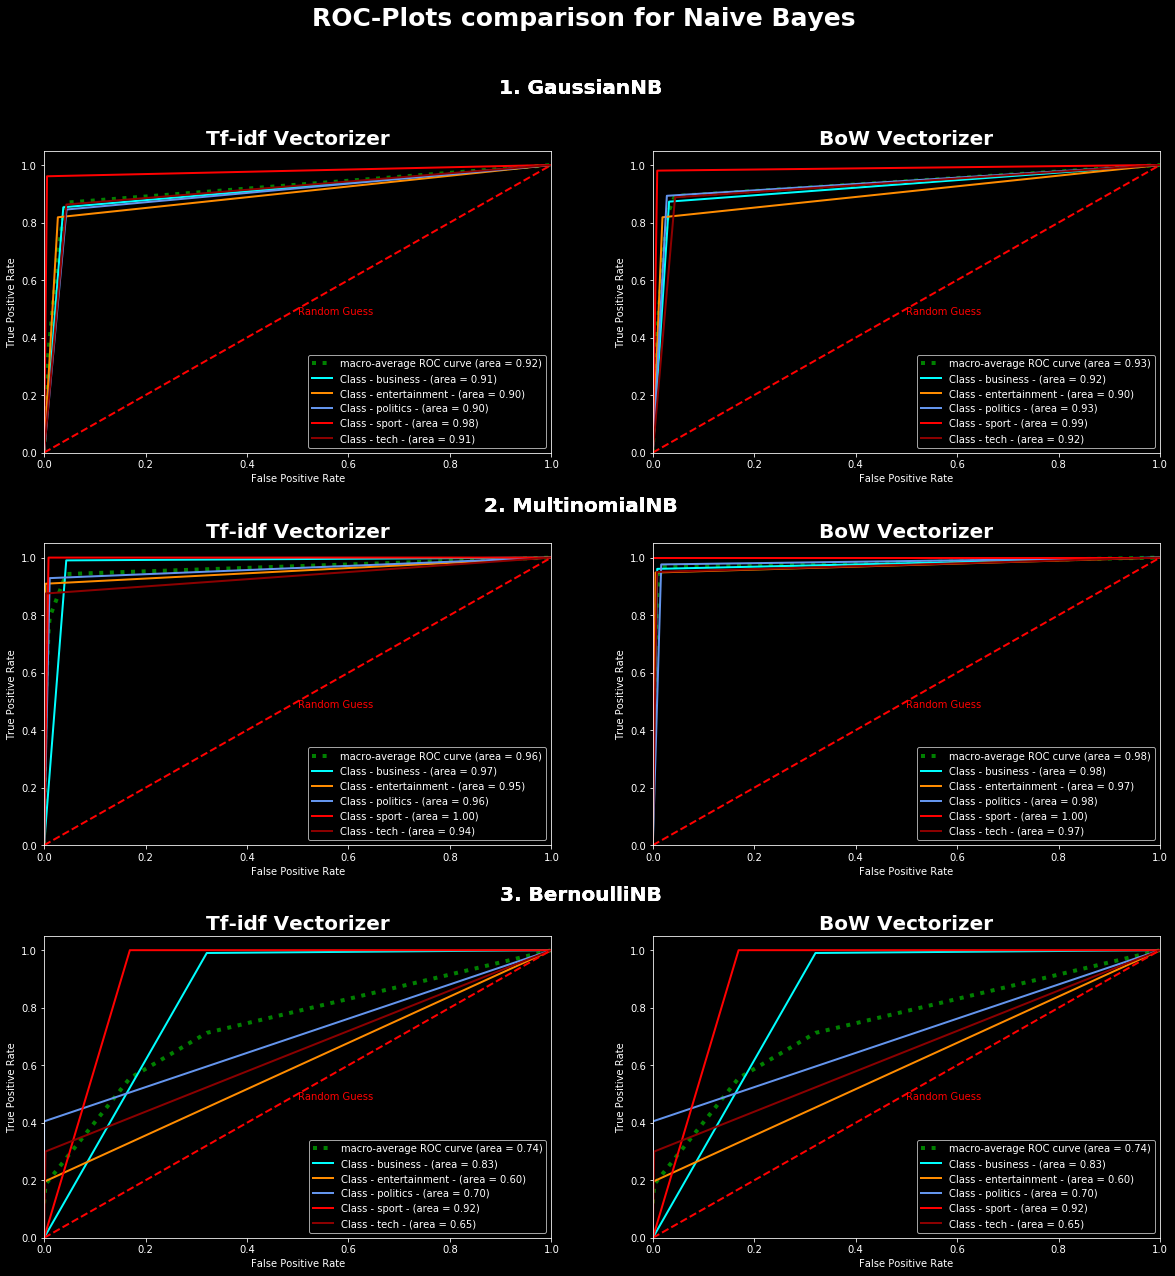

In [55]:
def naiveBayes_plots(estimators,y_test,t_test,b_test,folds,modelName):
    plt.style.use('dark_background')
    fig, axs = plt.subplots(3,2,figsize=(20,20))
    fig.subplots_adjust(hspace = 0.4)
    fig.suptitle(modelName,fontsize=25,fontweight='bold')
    i=0;j=0;
    for estimator in estimators:
        clf = OneVsRestClassifier(estimator)
        tfidf_predictions = cross_val_predict(estimator,t_test,y_test,cv=folds,method='predict')
        bow_predictions = cross_val_predict(estimator,b_test,y_test,cv=folds,method='predict')
        plt.figtext(0.5,0.93, "1. GaussianNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.figtext(0.5,0.64, "2. MultinomialNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.figtext(0.5,0.37, "3. BernoulliNB ", ha="center", va="top", fontsize=20,fontweight='bold')
        plt.subplots_adjust(hspace = 0.3 )
        create_ROCplot(5,tfidf_predictions,y_test,axs[i,j],'Tf-idf Vectorizer')    
        create_ROCplot(5,bow_predictions,y_test,axs[i,j+1],'BoW Vectorizer')
        j=0;i+=1;

estimators = [GaussianNB(),MultinomialNB(),BernoulliNB()]
naiveBayes_plots(estimators,y_test,tfidf_test,bow_test,folds,'ROC-Plots comparison for Naive Bayes')

# $\bullet$ K-Nearest Neighbour

In [32]:
class KNN:
    def __init__(self,k):
        self.k = k
    
    def fit(self,X,y):
        self.vectorized_X = X
        self._y_train = y
        
    def majorityVoting(self,neighbours):
        frequency = collections.Counter(t[1] for t in neighbours)
        return frequency.most_common(1)[0][0]    
    
    def get_neighbours(self,index_Y,topN,category_list,similarity_matrix):
        
        similarity_dictionary = {}
        for index_X in range(0,len(similarity_matrix[index_Y])):  # finding the most similar to the wanted id
            XYtuple = (index_X,category_list[index_X])
            similarity_dictionary[XYtuple] = similarity_matrix[index_Y][index_X]


        sortedDict = {k : similarity_dictionary[k] for k in sorted(similarity_dictionary,key = similarity_dictionary.get,reverse=True)}
        if topN>len(similarity_matrix[index_Y]): # checking if topN is greater that the size of list
            topN=len(similarity_matrix[index_Y])
        out = dict(itertools.islice(sortedDict.items(),topN))
        neighbours = []
        for k,v in out.items():
            neighbours.append(k)

        return neighbours

    def predict(self,X):
        
        similarity_matrix = cosine_similarity(X,self.vectorized_X)
        category_list = self._y_train.tolist()
        predictions = []

        for i in range(similarity_matrix.shape[0]):
            neighbours = self.get_neighbours(i,self.k,category_list,similarity_matrix)
            category = self.majorityVoting(neighbours)
            predictions.append(category)
        
        return predictions

    def get_params(self,deep):
        params = {'k':self.k}
        return params

    def set_params(self, **params):
        for key, value in params.items():
            if(key=='k'):
                self.k = value
        return self

    def score(self,X,y,sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [34]:
knn_parameters = {
    'k' : [1,5,10,20,50]
}

knn = make_Classification(
    KNN(5),
    knn_parameters,tfidf_train,tfidf_test,bow_train,bow_test,y_train,y_test,
    wantedColumns = ['Vectorizer','param_k','mean_test_accuracy','mean_test_precision_macro','mean_test_recall_macro', 'mean_test_f1_macro'],
    nameDict = {'param_k': 'Number of neighbours','mean_test_accuracy':'Accuracy','mean_test_precision_macro':'Precision (macro)','mean_test_recall_macro':'Recall (macro)', 'mean_test_f1_macro':'F-Measure (macro)'},
)
knn.style.format("{:.2%}",subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).apply(highlight_max,subset=['Accuracy','Precision (macro)','Recall (macro)','F-Measure (macro)']).hide_index()

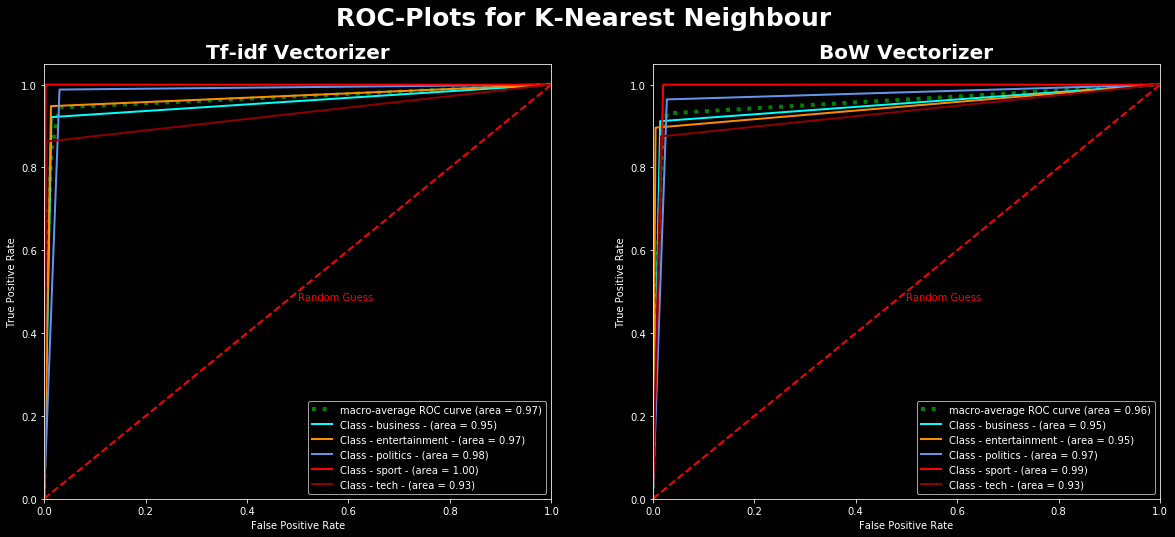

In [104]:
create_plots(KNN(50),y_test,tfidf_test,bow_test,folds,'ROC-Plots for K-Nearest Neighbour')

# 3. Beat the Benchmark


# 4. Clustering

In [ ]:
contentlist = X_train.values
sentences = []
for x in contentlist:
    textWords = []
    for y in word_tokenize(x):
        y = y.lower()
        y = WordNetLemmatizer().lemmatize(y)
        y.replace('\n','')
        if y not in punctuation:
            textWords.append(y)
    sentences.append(textWords)

In [ ]:
 def K_Means_plot(components,real_data,title,labels):
    plt.style.use('dark_background')

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 10))
   #  fig.suptitle(title)

    ax1.scatter(components[0], components[1],c=labels, s=50, cmap='viridis')
    ax1.set_xlabel('Similarity-X')
    ax1.set_ylabel('Similarity-Y')
    ax1.set_title(title)
    ax1.grid(True)

    noCluster_plot(components,real_data,ax2,'Real Data') 

In [ ]:
def noCluster_plot(components,data,ax,title):
    ax.scatter(components[0], components[1],c=data, s=50, cmap='viridis')
    ax.set_xlabel('Similarity-X')
    ax.set_ylabel('Similarity-Y')
    ax.set_title(title)
    # ax.legend()
    ax.grid(True)

In [ ]:
def compositionModel(model,data):
    model.fit(data)
    composed_data = model.fit_transform(data)
    model_components = pd.DataFrame(composed_data)
    return model_components

In [ ]:
def K_MeansClustering(data):
    normalized_data = preprocessing.normalize(data)
    km = KMeans(n_clusters=5)
    labels = km.fit_predict(normalized_data) # Fit model to samples
    return labels

In [ ]:
from sklearn import preprocessing  # to normalise existing X

def modelPlots(model,w2v_data,tfidf_data,bow_data,real_data):
    labels = K_MeansClustering(tfidf_data)
    components = compositionModel(model,tfidf_data.todense())
    K_Means_plot(components,y_train,'Tfidf Data',labels)
    labels = K_MeansClustering(w2v_data)
    components = compositionModel(model,w2v_data)
    K_Means_plot(components,y_train,'Word2vec Data',labels)
    labels = K_MeansClustering(bow_data)
    components = compositionModel(model,bow_data)
    K_Means_plot(components,y_train,'Bow Data',labels)

In [ ]:
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        # if word in index2word_set:
        nwords = nwords+1
        featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [ ]:
from gensim.models import Word2Vec

vectorizedSent = []
word2vec_model = Word2Vec(sentences, min_count = 1, window = 5) 
for text in sentences:
    sentence = avg_sentence_vector(text, model=word2vec_model, num_features=100,index2word_set=set(word2vec_model.wv.vocab))
    vectorizedSent.append(sentence)

# Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA 
modelPlots(PCA(n_components=2),vectorizedSent,tfidf_train,bow_train.todense(),y_train)

# Singular Value Decomposition (SVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD

modelPlots(TruncatedSVD(n_components=2, random_state=None),vectorizedSent,tfidf_train,bow_train.todense(),y_train) 

# Independent Component Analysis (ICA)